In [1]:
%env NGSPICE_LIBRARY_PATH=/usr/local/lib/libngspice.so

env: NGSPICE_LIBRARY_PATH=/usr/local/lib/libngspice.so


In [2]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging(logging_level="WARNING")

from PySpice.Spice.Netlist import Circuit, SubCircuit
import PySpice.Unit as un
import numpy as np
import matplotlib.pyplot as plt

class RCBlock(SubCircuit):
    NODES = ('n1', 'n2')
    def __init__(self, name, R=1000 @ un.u_kOhm, C=2 @ un.u_uF):
        super().__init__(name, *self.NODES)
        self.R(1, 'n1', 'n2', R)
        self.C(1, 'n1', 'n2', C)

TIME_SCALE = 1.0

def pulse_params(**kwargs):
    params = dict(
        num_pulses=20000,
        pulse_period=0.2,
        pulse_on=0.02,
        amplitude=1,
    )
    params.update(kwargs)
    params["pulse_period"] *= TIME_SCALE
    params["pulse_on"] *= TIME_SCALE
    return params

def simulate(pulse_params_1, pulse_params_2):
    circuit = Circuit("Test")
    circuit.subcircuit(RCBlock("rc1"))
    circuit.subcircuit(RCBlock("rc2", C=200 @ un.u_uF))

    delay = 0.2
    if pulse_params_2["amplitude"] != 0:
        dt = pulse_params_2["num_pulses"] * pulse_params_2["pulse_period"]
        dt -= (dt % pulse_params_1["pulse_period"])
        dt += pulse_params_1["pulse_period"]
        delay = 0.2 + dt
    circuit.V("input1", "node0a", circuit.gnd, "DC 0 PULSE(0 {amplitude} {delay} 0 0 {pulse_on} {pulse_period} {num_pulses}) AC 0".format(**pulse_params_1, delay=delay))
    circuit.V("input2", "node0", "node0a", "DC 0 PULSE(0 {amplitude} {delay} 0 0 {pulse_on} {pulse_period} {num_pulses}) AC 0".format(**pulse_params_2, delay=0.2))
    circuit.X("B1", "rc1", "node0", "node1")
    circuit.R(1, "node1", "node2", 1000 @ un.u_kOhm)
    circuit.X("B2", "rc2", "node2", circuit.gnd)

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    analysis = simulator.transient(step_time=0.1 @ un.u_ms, end_time=(300 * TIME_SCALE) @ un.u_s)

    return analysis.time.as_ndarray(), analysis.nodes["node2"].as_ndarray() - analysis.nodes["node1"].as_ndarray()

tt1, sim1 = simulate(
    pulse_params(),
    pulse_params(pulse_period=0.1, num_pulses=1000, pulse_on=0.05),
)
tt2, sim2 = simulate(
    pulse_params(),
    pulse_params(amplitude=0),
)

2023-03-24 19:18:33,635 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 39


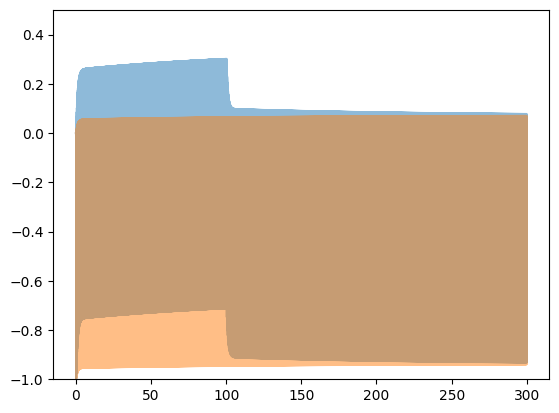

In [3]:
plt.plot(
    tt1, sim1, alpha=0.5,
)
plt.plot(
    tt2, sim2,
    alpha=0.5,
)
plt.ylim(-1, sim1.max() + 0.2);